# Market Making with Alpha - Order Book Imbalance

## Overview

Order Book Imbalance, also known as Order Flow Imbalance, is a widely recognized microstructure indicator often analyzed alongside trade flow. This concept has several derivatives, including the Micro-Price, VAMP (Volume Adjusted Mid Price), Weighted-Depth Order Book Price, and Static Order Book Imbalance, among others. These derivatives may also undergo statistical adjustments, such as standardization. Extensive information is available online regarding these indicators. In the examples that follow, we will these indicators.

### Reference
* [The Micro-Price: A High Frequency Estimator of Future Prices](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2970694)
* [Mind the Gaps: Short-Term Crypto Price Prediction](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4351947)
* [Market microstructure signals](https://blog.headlandstech.com/2017/08/)



<div class="alert alert-info">
    
**Note:** This example is for educational purposes only and demonstrates effective strategies for high-frequency market-making schemes. All backtests are based on a 0.005% rebate, the highest market maker rebate available on Binance Futures. See <a href="https://www.binance.com/en/support/announcement/binance-updates-usd%E2%93%A2-margined-futures-liquidity-provider-program-2024-06-03-fefc6aa25e0947e2bf745c1c56bea13e">Binance Upgrades USDⓢ-Margined Futures Liquidity Provider Program</a> for more details.
    
</div>

In [1]:
import numpy as np

from numba import njit, uint64
from numba.typed import Dict

from hftbacktest import (
    BacktestAsset,
    ROIVectorMarketDepthBacktest,
    GTX,
    LIMIT,
    BUY,
    SELL,
    BUY_EVENT,
    SELL_EVENT,
    Recorder
)
from hftbacktest.stats import LinearAssetRecord

@njit
def obi_mm(
    hbt,
    stat,
    half_spread,
    skew,
    c1,
    looking_depth,
    interval,
    window,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval,
    roi_lb,
    roi_ub
):
    asset_no = 0
    imbalance_timeseries = np.full(30_000_000, np.nan, np.float64)

    tick_size = hbt.depth(0).tick_size
    lot_size = hbt.depth(0).lot_size
    
    t = 0
    roi_lb_tick = int(round(roi_lb / tick_size))
    roi_ub_tick = int(round(roi_ub / tick_size))
    
    while hbt.elapse(interval) == 0:
        hbt.clear_inactive_orders(asset_no)
        
        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        orders = hbt.orders(asset_no)

        best_bid = depth.best_bid
        best_ask = depth.best_ask
        
        mid_price = (best_bid + best_ask) / 2.0
        
        sum_ask_qty = 0.0
        from_tick = max(depth.best_ask_tick, roi_lb_tick)
        upto_tick = min(int(np.floor(mid_price * (1 + looking_depth) / tick_size)), roi_ub_tick)
        for price_tick in range(from_tick, upto_tick):
            sum_ask_qty += depth.ask_depth[price_tick - roi_lb_tick]
                
        sum_bid_qty = 0.0
        from_tick = min(depth.best_bid_tick, roi_ub_tick)
        upto_tick = max(int(np.ceil(mid_price * (1 - looking_depth) / tick_size)), roi_lb_tick)
        for price_tick in range(from_tick, upto_tick, -1):
            sum_bid_qty += depth.bid_depth[price_tick - roi_lb_tick]

        imbalance_timeseries[t] = sum_bid_qty - sum_ask_qty
        
        # Standardizes the order book imbalance timeseries for a given window
        m = np.nanmean(imbalance_timeseries[max(0, t + 1 - window):t + 1])
        s = np.nanstd(imbalance_timeseries[max(0, t + 1 - window):t + 1]) 
        alpha = np.divide(imbalance_timeseries[t] - m, s)
    
        #--------------------------------------------------------
        # Computes bid price and ask price.
        
        order_qty = max(round((order_qty_dollar / mid_price) / lot_size) * lot_size, lot_size)
        fair_price = mid_price + c1 * alpha
        
        normalized_position = position / order_qty
        
        reservation_price = fair_price - skew * normalized_position

        bid_price = min(np.round(reservation_price - half_spread), best_bid)
        ask_price = max(np.round(reservation_price + half_spread), best_ask)
        
        bid_price = np.floor(bid_price / tick_size) * tick_size
        ask_price = np.ceil(ask_price / tick_size) * tick_size
        
        #--------------------------------------------------------
        # Updates quotes.
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if position * mid_price < max_position_dollar and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price
                
                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if position * mid_price > -max_position_dollar and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval
                
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)
                    
        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
                
        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
        
        t += 1
        
        if t >= len(imbalance_timeseries):
            raise Exception
        
        # Records the current state for stat calculation.
        stat.record(hbt)

In [2]:
%%time

roi_lb = 10000
roi_ub = 50000

latency_data = np.concatenate(
[np.load('latency/live_order_latency_{}.npz'.format(date))['data'] for date in range(20230501, 20230532)]
)

asset = (
    BacktestAsset()
        .data(['data2/btcusdt_{}.npz'.format(date) for date in range(20230501, 20230532)])
        .initial_snapshot('data2/btcusdt_20230430_eod.npz')
        .linear_asset(1.0) 
        .intp_order_latency(latency_data)
        .power_prob_queue_model(2)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .roi_lb(roi_lb)    
        .roi_ub(roi_ub)
)

hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 30_000_000)

half_spread = 80
skew = 3.5
c1 = 160
depth = 0.025 # 2.5% from the mid price
interval = 1_000_000_000 # 1s
window = 3_600_000_000_000 / interval # 1hour
order_qty_dollar = 50_000
max_position_dollar = order_qty_dollar * 50
grid_num = 1
grid_interval = hbt.depth(0).tick_size

obi_mm(
    hbt,
    recorder.recorder,
    half_spread,
    skew,
    c1,
    depth,
    interval,
    window,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval,
    roi_lb,
    roi_ub
)

hbt.close()

recorder.to_npz('stats/obi_btcusdt.npz')

CPU times: user 32min 23s, sys: 43.9 s, total: 33min 7s
Wall time: 33min 5s


In [3]:
data = np.load('stats/obi_btcusdt.npz')['0']
stats = (
    LinearAssetRecord(data)
        .resample('5m')
        .stats(book_size=2_500_000)
)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2023-05-01 00:00:00,2023-05-30 23:55:00,10.829336,13.5994,0.342371,0.037249,4119.876838,82.397448,9.191522,0.000139,2.6383e6


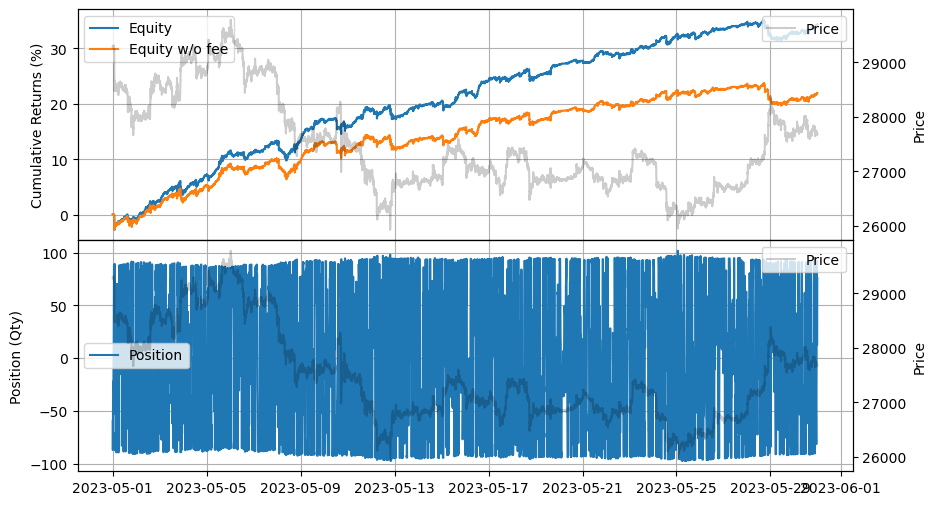

In [4]:
stats.plot()

In [5]:
%%time

roi_lb = 0
roi_ub = 3000

latency_data = np.concatenate(
[np.load('latency/live_order_latency_{}.npz'.format(date))['data'] for date in range(20230501, 20230532)]
)

asset = (
    BacktestAsset()
        .data(['data2/ethusdt_{}.npz'.format(date) for date in range(20230501, 20230532)])
        .initial_snapshot('data2/ethusdt_20230430_eod.npz')
        .linear_asset(1.0) 
        .intp_order_latency(latency_data)
        .power_prob_queue_model(2)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.01)
        .lot_size(0.001)
        .roi_lb(roi_lb)    
        .roi_ub(roi_ub)
)

hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 30_000_000)

half_spread = 5
skew = 0.2
c1 = 10
depth = 0.025 # 2.5% from the mid price
interval = 1_000_000_000 # 1s
window = 3_600_000_000_000 / interval # 1hour
order_qty_dollar = 50_000
max_position_dollar = order_qty_dollar * 50
grid_num = 1
grid_interval = hbt.depth(0).tick_size

obi_mm(
    hbt,
    recorder.recorder,
    half_spread,
    skew,
    c1,
    depth,
    interval,
    window,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval,
    roi_lb,
    roi_ub
)

hbt.close()

recorder.to_npz('stats/obi_ethusdt.npz')

CPU times: user 27min 37s, sys: 38.3 s, total: 28min 15s
Wall time: 28min 16s


In [6]:
data = np.load('stats/obi_ethusdt.npz')['0']
stats = (
    LinearAssetRecord(data)
        .resample('5m')
        .stats(book_size=2_500_000)
)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2023-05-01 00:00:00,2023-05-31 23:55:00,9.017874,11.140311,0.299582,0.055187,4112.621933,82.252375,5.428451,0.000118,2.6036e6


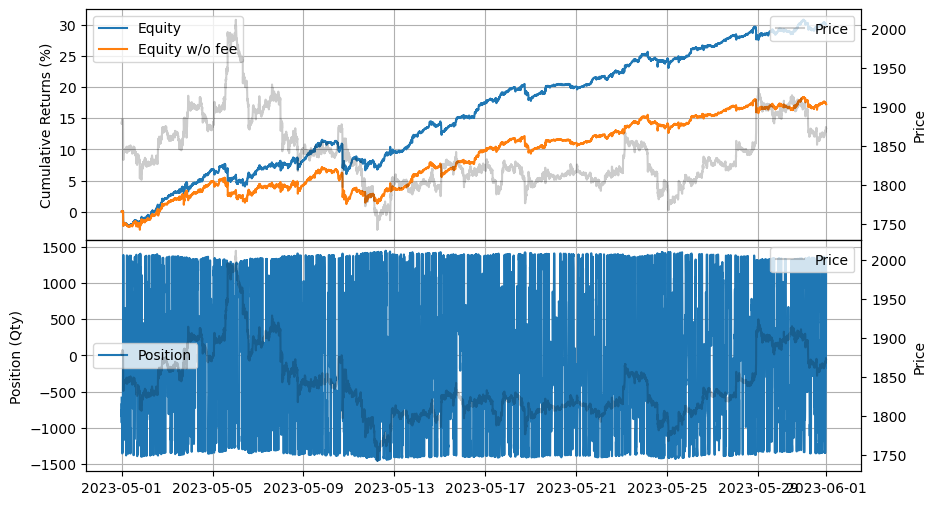

In [7]:
stats.plot()

Another approach is to generate trading volume to qualify as a market maker and receive rebates. This strategy involves maintaining a high skew and tight spread. While the strategy itself may not be profitable or may incur losses, it can help achieve market maker status.

In [8]:
%%time

roi_lb = 10000
roi_ub = 50000

latency_data = np.concatenate(
[np.load('latency/live_order_latency_{}.npz'.format(date))['data'] for date in range(20230501, 20230532)]
)

asset = (
    BacktestAsset()
        .data(['data2/btcusdt_{}.npz'.format(date) for date in range(20230501, 20230532)])
        .initial_snapshot('data2/btcusdt_20230430_eod.npz')
        .linear_asset(1.0) 
        .intp_order_latency(latency_data)
        .power_prob_queue_model(2)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .roi_lb(roi_lb)    
        .roi_ub(roi_ub)
)

hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 30_000_000)

half_spread = 10
skew = 2
c1 = 20
depth = 0.001 # 0.1% from the mid price
interval = 500_000_000 # 500ms
window = 600_000_000_000 / interval # 10min
order_qty_dollar = 25_000
max_position_dollar = order_qty_dollar * 20
grid_num = 1
grid_interval = hbt.depth(0).tick_size

obi_mm(
    hbt,
    recorder.recorder,
    half_spread,
    skew,
    c1,
    depth,
    interval,
    window,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval,
    roi_lb,
    roi_ub
)

recorder.to_npz('stats/obi_vg_btcusdt.npz')

CPU times: user 30min 13s, sys: 44.1 s, total: 30min 57s
Wall time: 31min 2s


In [9]:
data = np.load('stats/obi_vg_btcusdt.npz')['0']
stats = (
    LinearAssetRecord(data)
        .resample('5m')
        .stats()
)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTradingValue,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2023-05-01 00:00:00,2023-05-30 23:55:00,14.011326,17.369939,129920.543525,9279.613145,8368.335224,2.0921e8,14.000642,0.000021,536859.7998


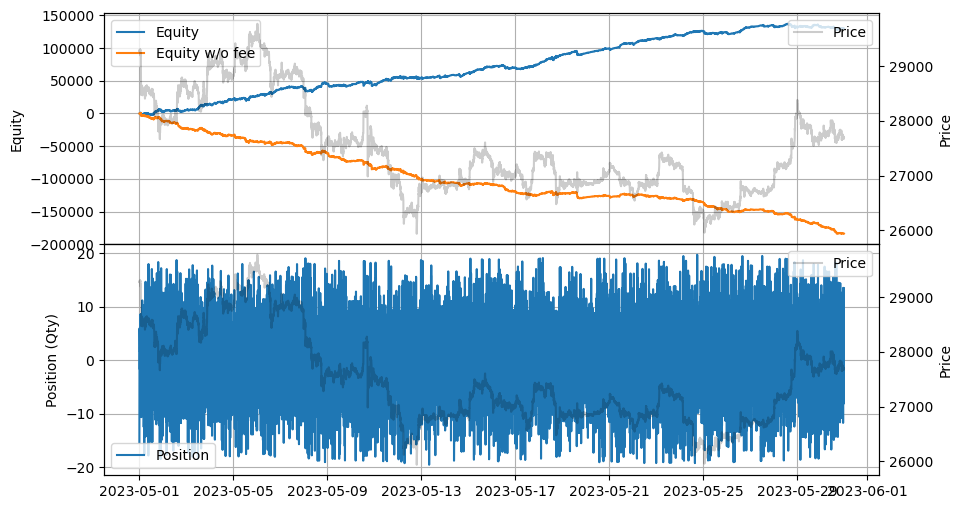

In [10]:
stats.plot()